In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
filename = "Validation_Prediction_OriFeature_DeGas_Expectation_Spearman0.8_UpdateRec_AnalCancer_StratiTrainValTest_Average.xlsx"
data = pd.read_excel(filename, "Combine")
RFS12 = "12monRFS"
RFS24 = "24monRFS"
RFS36 = "36monRFS"
figuretitle = 'ROC Curves (Radiomics Model)'

In [3]:
data

,PatientsID,Prediction,Duration,Recurrence
0,5007194,1104.367818,413,0
1,70028521,1095.311543,602,0
2,70057487,690.430996,935,0
3,70234176,117.081448,0,1
4,70278537,928.245941,1200,0
...,...,...,...,...
91,95060777,607.631792,588,0
92,95098555,834.172321,508,0
93,95139834,928.960683,185,0
94,95947521,1092.895379,366,0


In [4]:
from statistics import median
predicMed = median(data['Prediction'].values)
predicMed

993.9296858743389

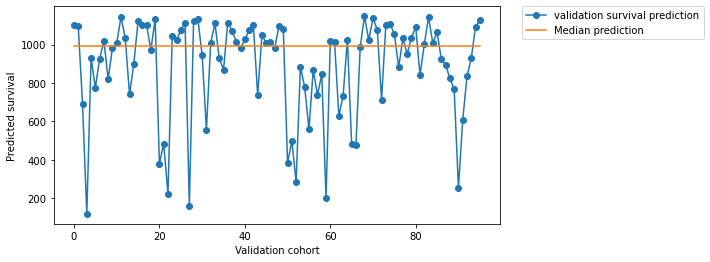

In [5]:
fig = plt.figure(figsize=(8,4))

ax = fig.add_subplot(111)
ax.set_xlabel("Validation cohort")
ax.set_ylabel("Predicted survival")
plt.plot(data['Prediction'].values,'o-', label="validation survival prediction")
plt.plot(np.ones(len(data['Prediction']))*predicMed, label="Median prediction")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [6]:
low_risk_ind = np.argwhere(data['Prediction'].values >= predicMed)
high_risk_ind = np.argwhere(data['Prediction'].values < predicMed)

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          13.57 <0.005     12.09

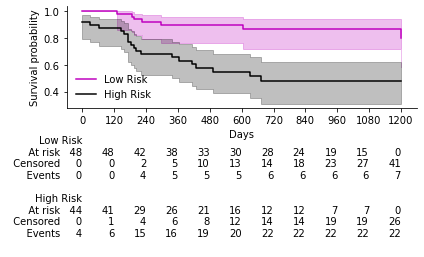

In [7]:
import lifelines
from lifelines.plotting import add_at_risk_counts
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index

duration = data[['Duration']]
event = data[['Recurrence']]

cum_event = event
cum_duration = duration

durations = cum_duration.to_numpy()
events= cum_event.to_numpy()

ax = plt.subplot(111)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

kmf_low = lifelines.KaplanMeierFitter()
ax = kmf_low.fit(durations[low_risk_ind], event_observed=events[low_risk_ind], label="Low Risk").plot_survival_function(show_censors=False,ci_show=True, ax=ax,color='m')

kmf_high = lifelines.KaplanMeierFitter()
ax = kmf_high.fit(durations[high_risk_ind], event_observed=events[high_risk_ind], label="High Risk").plot_survival_function(show_censors=False,ci_show=True, ax=ax,color='k') #, linestyle='dashed'
plt.xticks(np.linspace(0,1200,11))
plt.xlabel('Days')
plt.ylabel('Survival probability')
plt.legend(frameon=False)

add_at_risk_counts(kmf_low, kmf_high, ax=ax)
plt.tight_layout()
# plt.savefig('DFS_Radiomics_Risk_0_Partition_Italy.png', dpi=300)

results = logrank_test(durations[high_risk_ind], durations[low_risk_ind], events[high_risk_ind], events[low_risk_ind], alpha=.95)

results.print_summary()

In [8]:
import copy
from sklearn.model_selection import KFold
from lifelines.utils import concordance_index
from sklearn import metrics

In [9]:
Cindex_val = concordance_index(
    event_times=data['Duration'], 
    predicted_scores = data['Prediction'], 
    event_observed= data['Recurrence'],
)
Cindex_val

0.7554605887939221

In [10]:
data12 = pd.read_excel(filename, RFS12)
data24 = pd.read_excel(filename, RFS24)
data36 = pd.read_excel(filename, RFS36)

In [14]:
fpr12, tpr12, thr12 = metrics.roc_curve(data12['Recurrence'], -data12['Prediction'])
auc12 = metrics.roc_auc_score(data12['Recurrence'].values,-data12['Prediction'].values)

fpr24, tpr24, thr24 = metrics.roc_curve(data24['Recurrence'], -data24['Prediction'])
auc24 = metrics.roc_auc_score(data24['Recurrence'].values,-data24['Prediction'].values)

fpr36, tpr36, thr36 = metrics.roc_curve(data36['Recurrence'], -data36['Prediction'])
auc36 = metrics.roc_auc_score(data36['Recurrence'].values,-data36['Prediction'].values)

In [15]:
# # sensitivity specificity
# from sklearn.metrics import confusion_matrix

# # threshold = predicMed
# threshold = 365*1
# predicted_class12 = np.zeros(data12['Prediction'].shape)
# predicted_class12[data12['Prediction'].values<=threshold]=1
# cm12 = confusion_matrix(data12['Recurrence'].values,predicted_class12)
# print('Confusion Matrix 12mon RFS: \n', cm12)

# threshold = 365*2
# predicted_class24 = np.zeros(data24['Prediction'].shape)
# predicted_class24[data24['Prediction'].values<=threshold]=1
# cm24 = confusion_matrix(data24['Recurrence'].values,predicted_class24)
# print('Confusion Matrix 12mon RFS: \n', cm24)

# threshold = 365*3
# predicted_class36 = np.zeros(data36['Prediction'].shape)
# predicted_class36[data36['Prediction'].values<=threshold]=1
# cm36 = confusion_matrix(data36['Recurrence'].values,predicted_class36)
# print('Confusion Matrix 12mon RFS: \n', cm36)

In [16]:
# sensitivity specificity
from sklearn.metrics import confusion_matrix

predicMed12 = median(data12['Prediction'].values)
threshold12 = predicMed12
predicted_class12 = np.zeros(data12['Prediction'].shape)
predicted_class12[data12['Prediction'].values<=threshold12]=1
cm12 = confusion_matrix(data12['Recurrence'].values,predicted_class12)
print('Confusion Matrix 12mon RFS: \n', cm12)

predicMed24 = median(data24['Prediction'].values)
threshold24 = predicMed24
predicted_class24 = np.zeros(data24['Prediction'].shape)
predicted_class24[data24['Prediction'].values<=threshold24]=1
cm24 = confusion_matrix(data24['Recurrence'].values,predicted_class24)
print('Confusion Matrix 12mon RFS: \n', cm24)

predicMed36 = median(data36['Prediction'].values)
threshold36 = predicMed36
predicted_class36 = np.zeros(data36['Prediction'].shape)
predicted_class36[data36['Prediction'].values<=threshold36]=1
cm36 = confusion_matrix(data36['Recurrence'].values,predicted_class36)
print('Confusion Matrix 12mon RFS: \n', cm36)

Confusion Matrix 12mon RFS: 
 [[37 26]
 [ 5 17]]
Confusion Matrix 12mon RFS: 
 [[27 12]
 [ 6 22]]
Confusion Matrix 12mon RFS: 
 [[15  6]
 [ 9 19]]


In [17]:
total=sum(sum(cm12))
accuracy12=(cm12[0,0]+cm12[1,1])/total
print ('Accuracy 12mon: ', accuracy12)
specificity12 = cm12[0,0]/(cm12[0,0]+cm12[0,1])
print('Sensitivity 12mon: ', specificity12)
sensitivity12 = cm12[1,1]/(cm12[1,0]+cm12[1,1])
print('Specificity 12mon: ', sensitivity12)

Accuracy 12mon:  0.6352941176470588
Sensitivity 12mon:  0.5873015873015873
Specificity 12mon:  0.7727272727272727


In [18]:
total=sum(sum(cm24))
accuracy24=(cm24[0,0]+cm24[1,1])/total
print ('Accuracy 24mon: ', accuracy24)
specificity24 = cm24[0,0]/(cm24[0,0]+cm24[0,1])
print('Sensitivity 24mon: ', specificity24)
sensitivity24 = cm24[1,1]/(cm24[1,0]+cm24[1,1])
print('Specificity 24mon: ', sensitivity24)

Accuracy 24mon:  0.7313432835820896
Sensitivity 24mon:  0.6923076923076923
Specificity 24mon:  0.7857142857142857


In [19]:
total=sum(sum(cm36))
accuracy36=(cm36[0,0]+cm36[1,1])/total
print ('Accuracy 36mon: ', accuracy36)
specificity36 = cm36[0,0]/(cm36[0,0]+cm36[0,1])
print('Sensitivity 36mon: ', specificity36)
sensitivity36 = cm36[1,1]/(cm36[1,0]+cm36[1,1])
print('Specificity 36mon: ', sensitivity36)

Accuracy 36mon:  0.6938775510204082
Sensitivity 36mon:  0.7142857142857143
Specificity 36mon:  0.6785714285714286


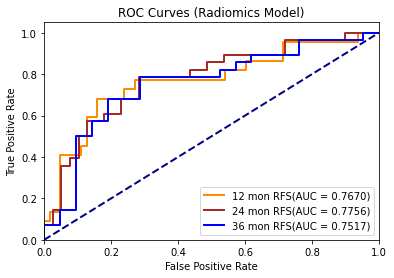

In [20]:
ax = plt.figure()
lw = 2
plt.plot(fpr12, tpr12, color="darkorange", lw=lw, label="12 mon RFS(AUC = %0.4f)" % auc12)
plt.plot(fpr24, tpr24, color="brown", lw=lw, label="24 mon RFS(AUC = %0.4f)" % auc24)
plt.plot(fpr36, tpr36, color="blue", lw=lw, label="36 mon RFS(AUC = %0.4f)" % auc36)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(figuretitle)
plt.legend(loc="lower right")
plt.show()

In [21]:
ax.savefig(figuretitle+'.tif', format='tif', dpi=1200)

In [22]:
# write AUC data to file
plots12 = np.column_stack([fpr12,tpr12])
plots12_df = pd.DataFrame(plots12,columns=['FPR-12','TPR-12'])
plots24 = np.column_stack([fpr24,tpr24])
plots24_df = pd.DataFrame(plots24,columns=['FPR-24','TPR-24'])
plots36 = np.column_stack([fpr36,tpr36])
plots36_df = pd.DataFrame(plots36,columns=['FPR-36','TPR-36'])
with pd.ExcelWriter(filename, engine='openpyxl', mode='a',if_sheet_exists="replace",) as writer:  
    plots12_df.to_excel(writer, sheet_name='AUCPlot12')
with pd.ExcelWriter(filename, engine='openpyxl', mode='a',if_sheet_exists="replace",) as writer:  
    plots24_df.to_excel(writer, sheet_name='AUCPlot24')
with pd.ExcelWriter(filename, engine='openpyxl', mode='a',if_sheet_exists="replace",) as writer:  
    plots36_df.to_excel(writer, sheet_name='AUCPlot36')
        

In [23]:
# write results to file
CI = [Cindex_val12,Cindex_val24,Cindex_val36]
AUC = AUC = [auc12,auc24,auc36]
Sen = [sensitivity12, sensitivity24, sensitivity36]
Spe = [specificity12, specificity24, specificity36]
Acu = [accuracy12, accuracy24, accuracy36]
results = np.column_stack([CI, AUC, Sen, Spe, Acu])
res_df = pd.DataFrame(results,columns=['C-Index','AUC','Sensitivity','Specificity','Accuracy'], 
                      index=['12mon','24mon', '36mon'])

with pd.ExcelWriter(filename, engine='openpyxl', mode='a') as writer:  
    res_df.to_excel(writer, sheet_name='ResultSummary')

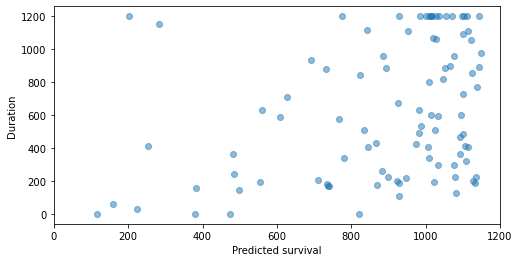

In [24]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
ax.set_xlabel("Predicted survival")
ax.set_ylabel("Duration")
plt.scatter(data['Prediction'].values,data['Duration'].values, alpha=0.5)
plt.xlim([0, 1200])
plt.show()